In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import sys

import torch
import torch.nn.functional as F

In [2]:
in_sample = "../pythia/output/dataset_diHiggs_mu20_NumEvents1k_MinJetpT25.root" # e.g. ../pythia/output/<file>.root
out_sample = "data/test.pkl" # e.g. data/<file>.pkl
out_dir = "plots/test" # e.g plots/<Dir Name>

print("Loading Sample into memory...")
with uproot.open(in_sample+":fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    trk_pt = f["trk_jet_pT"].array()
    trk_eta = f["trk_jet_eta"].array()
    trk_phi = f["trk_jet_phi"].array()
    trk_q = f["trk_jet_q"].array()
    trk_d0 = f["trk_jet_d0"].array()
    trk_z0 = f["trk_jet_z0"].array()
    trk_label = f["trk_jet_label"].array()
    jet_Efrac = f["jet_true_Efrac"].array()
    jet_Mfrac = f["jet_true_Mfrac"].array()

Loading Sample into memory...


In [3]:
print("Joining jet features...")
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_Efrac,jet_Mfrac]
jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)
print("\tNum Events: ", len(jet_feats))
print("\tNum Jets in first event: ", len(jet_feats[0]))
print("\tNum Jet Features: ", len(jet_feats[0][0]))

Joining jet features...
	Num Events:  1000
	Num Jets in first event:  17
	Num Jet Features:  6


In [4]:
print("Joining track features...")
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_label]
trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=3)
print("\tNum Events: ", len(trk_feats))
print("\tNum Jets in first event: ", len(trk_feats[0]))
print("\tNum Tracks in first event first jet: ", len(trk_feats[0][0]))
print("\tNum Tracks features: ", len(trk_feats[0][0][0]))

Joining track features...
	Num Events:  1000
	Num Jets in first event:  17
	Num Tracks in first event first jet:  58
	Num Tracks features:  7


In [5]:
print("Shuffling Events...")
# Shuffle events
p = np.random.permutation(len(jet_feats))
jet_feats = jet_feats[p]
trk_feats = trk_feats[p]

Shuffling Events...


In [6]:
print("Applying Cuts...")
# Apply Jet cuts
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

# Apply Track cuts
trk_q_cut = selected_tracks[:,:,:,3]!=0            # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4.5    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4          # 400MeV Cut
mask = trk_q_cut & trk_eta_cut & trk_pt_cut
selected_tracks = selected_tracks[mask]

# Skip trackless jets!
trackless_jets_mask = (ak.num(selected_tracks, axis=2)!=0)
selected_jets = selected_jets[trackless_jets_mask]
selected_tracks = selected_tracks[trackless_jets_mask]

Applying Cuts...


Normalizing Jet Features...


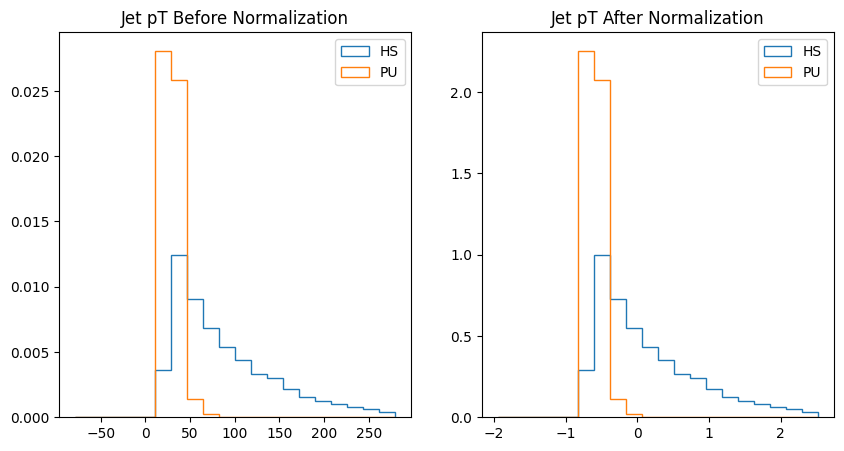

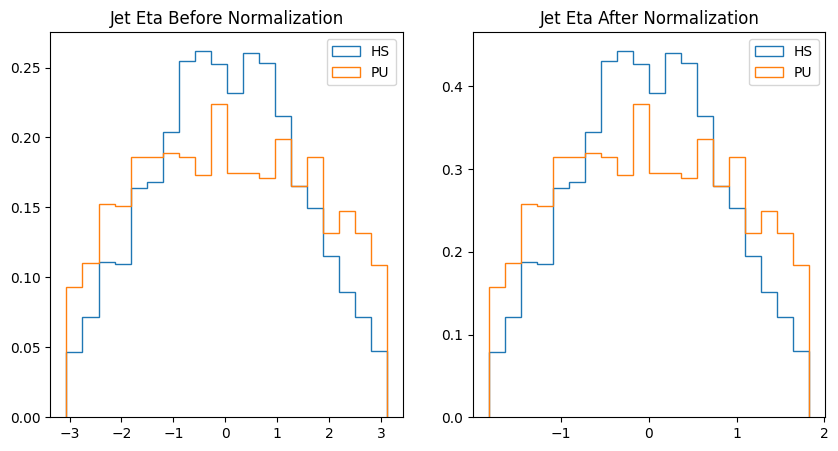

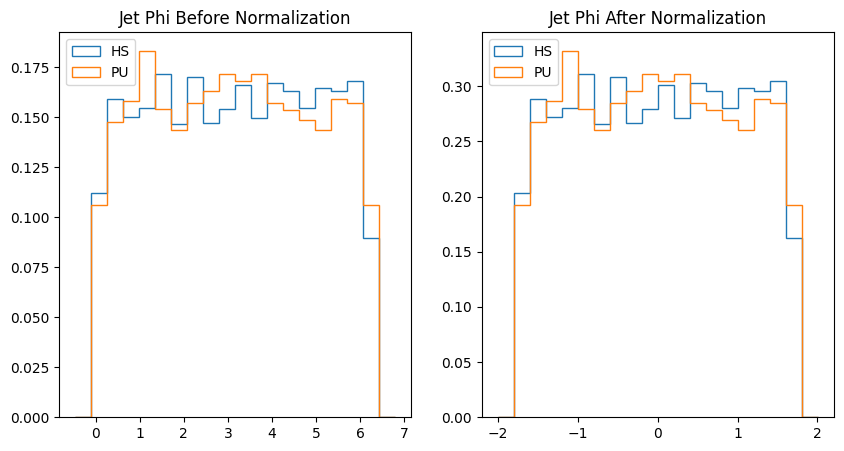

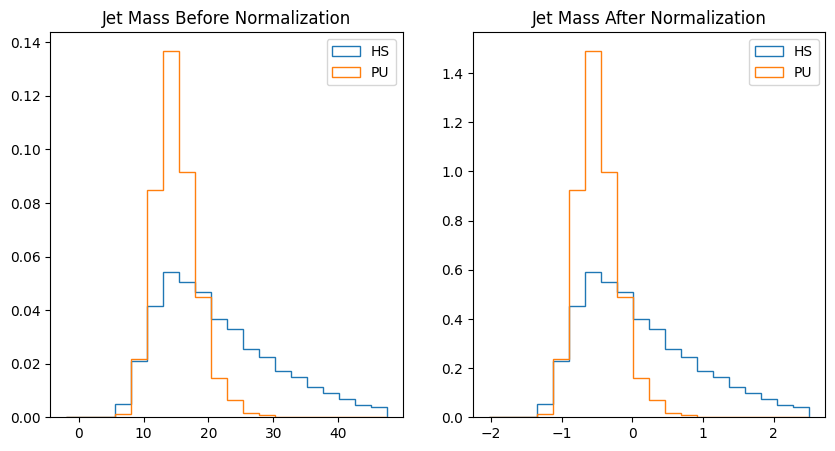

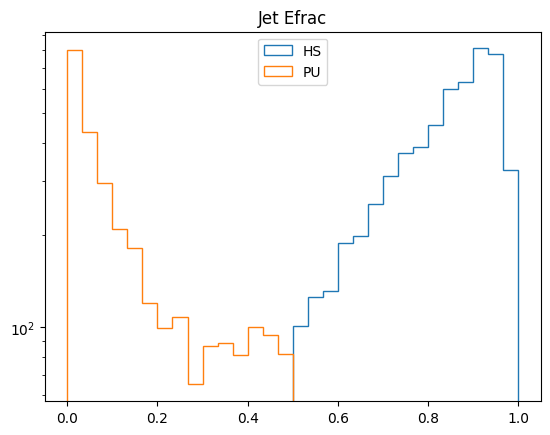

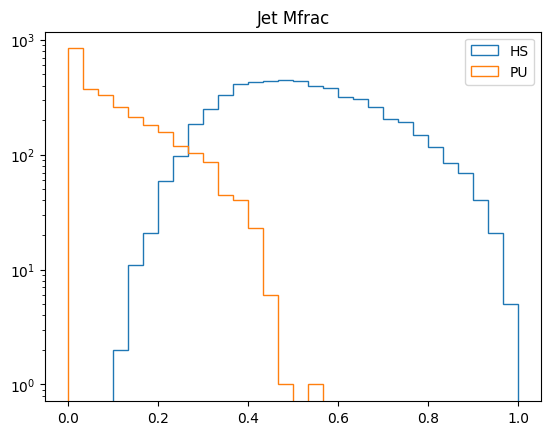

In [7]:
print("Normalizing Jet Features...")
num_jet_feats = len(selected_jets[0][0])-2

sig = selected_jets[:,:,-2]>0.5
bkg = ~sig

var_list = ['pT','Eta','Phi','Mass']

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title("Jet "+var_list[i]+" Before Normalization")
    ax1.legend()
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title("Jet "+var_list[i]+" After Normalization")
    ax2.legend()
    plt.savefig(out_dir+"/Normalized_Jet_"+var_list[i]+".png")
    #plt.show()
    #print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    #print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))

plt.figure()
plt.title("Jet Efrac")
plt.hist(ak.ravel(selected_jets[:,:,-2][sig]),histtype='step',label='HS',bins=30,range=(0,1))
plt.hist(ak.ravel(selected_jets[:,:,-2][bkg]),histtype='step',label='PU',bins=30,range=(0,1))
plt.yscale('log')
plt.legend()
plt.savefig(out_dir+"/Jet_Efrac.png")
#plt.show()

plt.figure()
plt.title("Jet Mfrac")
plt.hist(ak.ravel(selected_jets[:,:,-1][sig]),histtype='step',label='HS',bins=30,range=(0,1))
plt.hist(ak.ravel(selected_jets[:,:,-1][bkg]),histtype='step',label='PU',bins=30,range=(0,1))
plt.yscale('log')
plt.legend()
plt.savefig(out_dir+"/Jet_Mfrac.png")
#plt.show()

# Append Labels
norm_list.append(selected_jets[:,:,-2])
norm_list.append(selected_jets[:,:,-1])
Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

Normalizing Track Features...


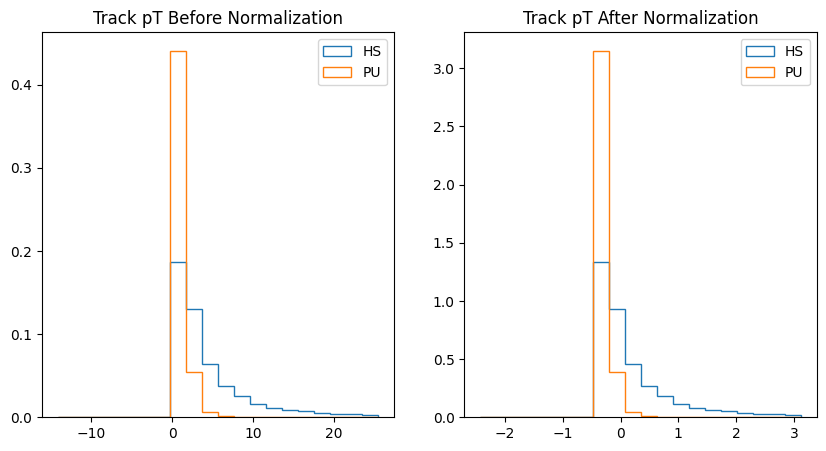

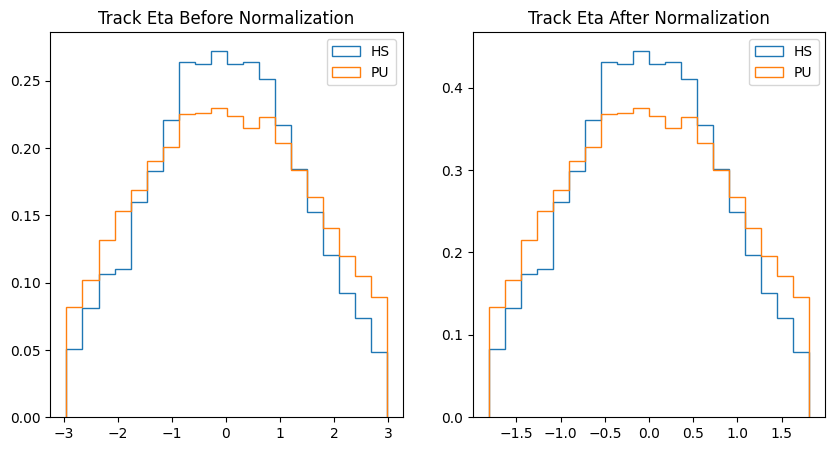

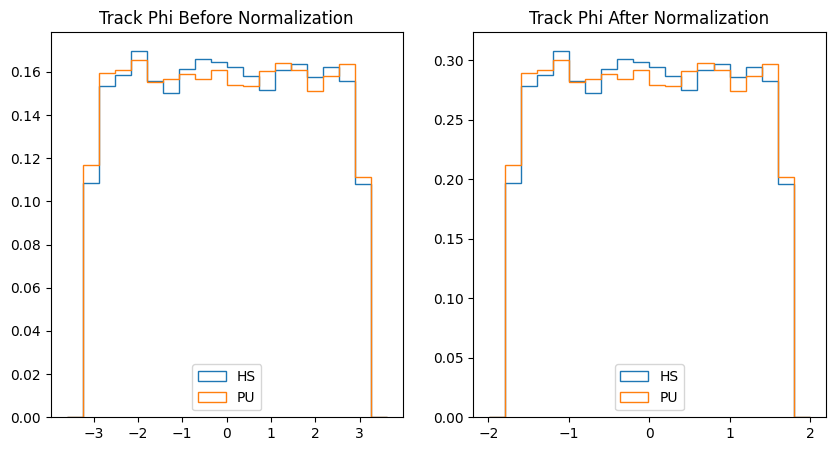

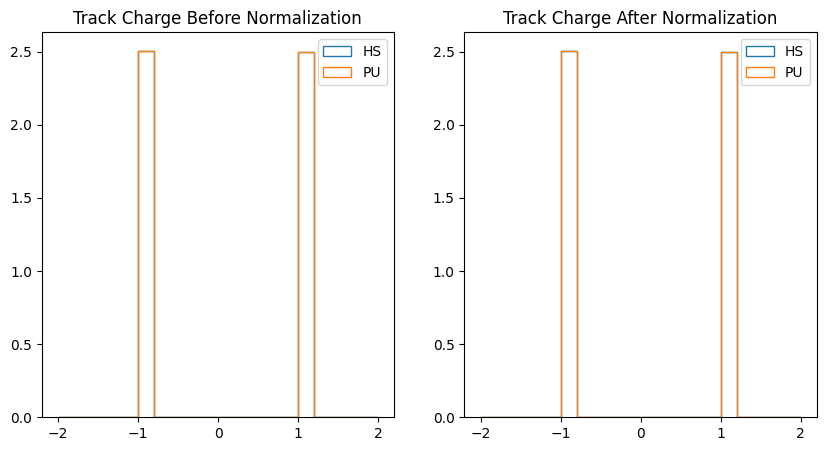

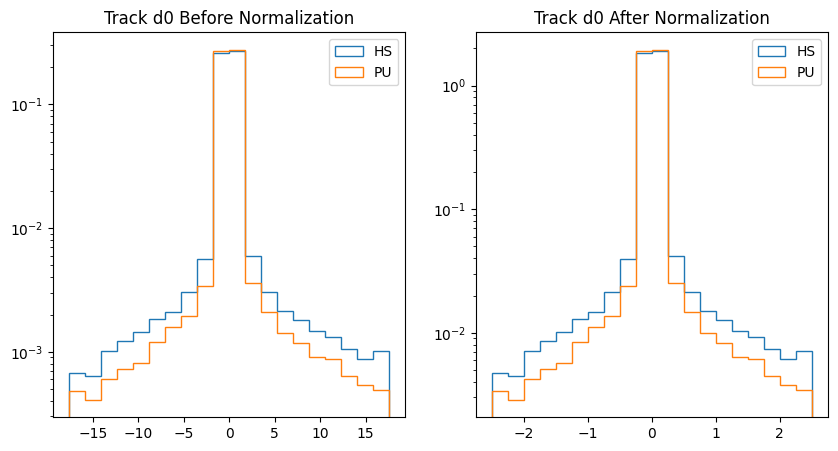

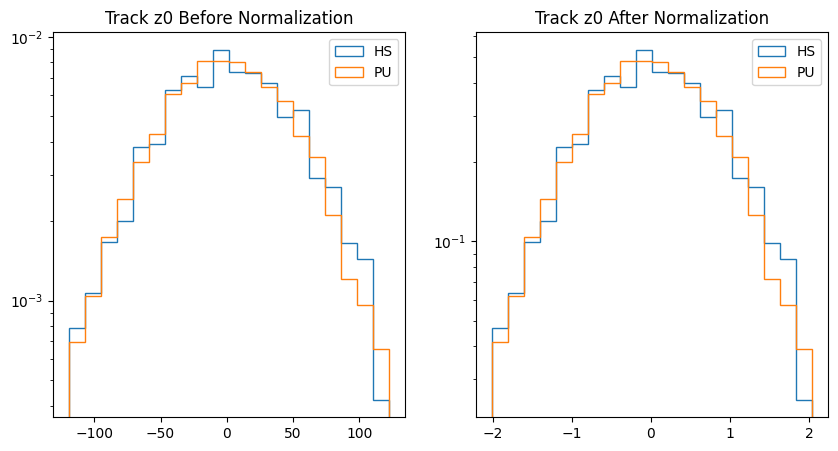

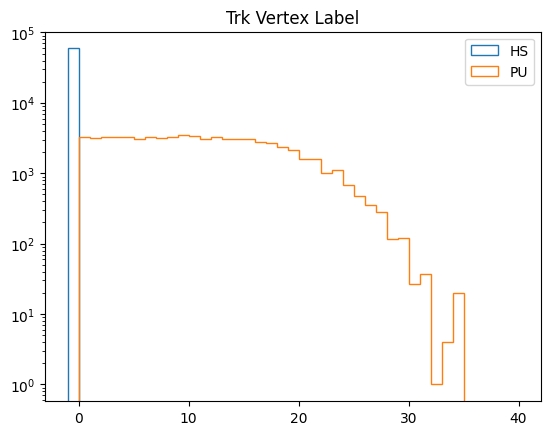

In [8]:
print("Normalizing Track Features...")
num_trk_feats = len(selected_tracks[0][0][0])-1

sig = selected_tracks[:,:,:,-1]==-1
bkg = ~sig

var_list = ['pT','Eta','Phi','Charge', 'd0', 'z0']

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title("Track "+var_list[i]+" Before Normalization")
    ax1.legend()
    if '0' in var_list[i]:
        ax1.set_yscale('log')
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title("Track "+var_list[i]+" After Normalization")
    ax2.legend()
    if '0' in var_list[i]:
        ax2.set_yscale('log')
    plt.savefig(out_dir+"/Normalized_Track_"+var_list[i]+".png")
    #plt.show()
    #print("Mean Before: ", mean, "\nMean After: ", ak.mean(norm))
    #print("STD Before: ", std, "\nSTD After: ", ak.std(norm))

plt.figure()
plt.title("Trk Vertex Label")
plt.hist(ak.ravel(selected_tracks[:,:,:,-1][sig]),histtype='step',label='HS',bins=41,range=(-1,40))
plt.hist(ak.ravel(selected_tracks[:,:,:,-1][bkg]),histtype='step',label='PU',bins=41,range=(-1,40))
plt.yscale('log')
plt.legend()
plt.savefig(out_dir+"/Trk_Label.png")
plt.show()
    
# Add label
isPU_label = ak.values_astype(selected_tracks[:,:,:,-1]!=-1,int)
norm_list.append(isPU_label)

# Combine features
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [9]:
print("Padding Tracks to common length...")
all_tracks = ak.flatten(selected_tracks, axis=2)
num_events = len(selected_jets)
Event_Data = []
Event_Labels = []
for event in range(num_events):
    if event%1==0:
        print("\tProcessing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])
        pad = (0,0,0,max_num_trks-len(tracks))
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    # Append all data *as torch tensors* to lists
    flat_tracks_data = torch.Tensor(all_tracks[event][:,0:-1])
    flat_tracks_label = torch.Tensor(all_tracks[event][:,-1])
    Event_Data.append((jets[:,0:-2],tracks[:,:,0:-1],flat_tracks_data))
    Event_Labels.append((jets[:,-2:],flat_tracks_label.reshape(-1,1)))
print("\tProcessing: ", num_events, " / ", num_events)

Padding Tracks to common length...
	Processing:  1000  /  1000


In [10]:
print("Split dataset into train, val, test...")
train_split = int(0.7*num_events)  # 70% train
test_split = int(0.75*num_events)  #  5% val + 25% test

Event_List = list(zip(Event_Data, Event_Labels))

Events_training = Event_List[0:train_split]
Events_validation = Event_List[train_split:test_split]
Events_testing = Event_List[test_split:]

print("\tTraining Events: ", len(Events_training))
print("\tValidation Events: ", len(Events_validation))
print("\tTesting Events: ", len(Events_testing))

X_train, y_train = list(zip(*Events_training))
X_val, y_val = list(zip(*Events_validation))
X_test, y_test = list(zip(*Events_testing))

data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle.dump(data, open( out_sample , "wb"))

Split dataset into train, val, test...
	Training Events:  700
	Validation Events:  50
	Testing Events:  250


In [11]:
debug=False
if debug:
    print("X_train Indices Reference:")
    print("\tNum Events: ", len(X_train))
    print("\tNum Tensors: ", len(X_train[0]), "(Jet, trk-jet, flat trk)")
    print("\tNum Jets: ", len(X_train[0][0]))
    print("\tNum Trks per Jet: ", len(X_train[0][1][0]))
    print("\tNum Flat Trks: ", len(X_train[0][2]))
    print("\tNum Jet Feats: ", len(X_train[0][0][0]))
    print("\tNum Trk Feats: ", len(X_train[0][1][0][0]))
    print()
    print("y_train Indices Reference:")
    print("\tNum Events: ", len(y_train))
    print("\tNum Jets: ", len(y_train[0]))

print("Done!")

Done!
